# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [86]:
!pip install pypdf

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:

import re
import io
import zipfile
from pathlib import Path

import pandas as pd
import requests
from pypdf import PdfReader


UCI_BANK_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"


def extract_campaign_count_from_pdf(pdf_path: str | Path) -> int | None:

    pdf_path = Path(pdf_path)
    reader = PdfReader(str(pdf_path))

    text = []
    for page in reader.pages:
        t = page.extract_text() or ""
        text.append(t)
    full_text = "\n".join(text)
    m = re.search(r"related\s+to\s+(\d+)\s+campaigns", full_text, flags=re.IGNORECASE)
    if m:
        return int(m.group(1))

    m2 = re.search(r"\b(\d+)\s+campaigns\b", full_text, flags=re.IGNORECASE)
    return int(m2.group(1)) if m2 else None


def download_and_load_uci_bank_full() -> pd.DataFrame:
    r = requests.get(UCI_BANK_ZIP_URL, timeout=60)
    r.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
        with zf.open("bank-full.csv") as f:
            df = pd.read_csv(f, sep=";")
    return df


def main():
    pdf_path = "/content/drive/My Drive/CRISP-DM-BANK.pdf"
    campaigns = extract_campaign_count_from_pdf(pdf_path)

    print(f"[PDF] Number of marketing campaigns (per CRISP-DM paper): {campaigns}")
    df = download_and_load_uci_bank_full()
    print("\n[UCI] Loaded bank-full.csv")
    print(f"      Rows (contacts): {len(df):,}")
    print(f"      Columns: {df.shape[1]}")
    cols = set(df.columns.str.lower())
    has_campaign_id = any(c in cols for c in ["campaign_id", "campaignid", "campaign_id"])

    if "month" in cols:
        print(f"      Unique months in data: {sorted(df['month'].unique().tolist())}")


if __name__ == "__main__":
    main()


[PDF] Number of marketing campaigns (per CRISP-DM paper): 17

[UCI] Loaded bank-full.csv
      Rows (contacts): 45,211
      Columns: 17
      Unique months in data: ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [89]:
import pandas as pd

In [90]:
df = pd.read_csv('/content/drive/My Drive/data/bank-additional-full.csv', sep = ';')

In [91]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [92]:

import io
import zipfile
from dataclasses import dataclass
from typing import Literal, Optional

import numpy as np
import pandas as pd
import requests

from __future__ import annotations

UCI_BANK_ADDITIONAL_ZIP_URL = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
)


MONTH_ORDER = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
DOW_ORDER = ["mon", "tue", "wed", "thu", "fri"]


@dataclass
class PreprocessConfig:
    unknown_to_nan: bool = True
    add_previously_contacted_flag: bool = True
    pdays_999_to_nan: bool = True
    temporal_encoding: Literal["ordered_category", "integer_codes"] = "integer_codes"
    encode_binary_yes_no: bool = True
    drop_duration: bool = True


def download_bank_additional_full() -> pd.DataFrame:
    r = requests.get(UCI_BANK_ADDITIONAL_ZIP_URL, timeout=60)
    r.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
        with zf.open("bank-additional/bank-additional-full.csv") as f:
            df = pd.read_csv(f, sep=";")
    return df


def coerce_unknown_to_nan(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].replace("unknown", np.nan)
    return df


def encode_yes_no_unknown(series: pd.Series, unknown_to_nan: bool) -> pd.Series:

    s = series.astype("string")
    if unknown_to_nan:
        s = s.replace("unknown", pd.NA)
    mapping = {"yes": 1, "no": 0}
    out = s.map(mapping)
    return out.astype("Int64")


def encode_temporal(
    df: pd.DataFrame, config: PreprocessConfig, month_col: str = "month", dow_col: str = "day_of_week"
) -> pd.DataFrame:
    if month_col in df.columns:
        if config.temporal_encoding == "ordered_category":
            df[month_col] = pd.Categorical(df[month_col], categories=MONTH_ORDER, ordered=True)
        else:
            month_map = {m: i + 1 for i, m in enumerate(MONTH_ORDER)}
            df[month_col] = df[month_col].map(month_map).astype("Int64")

    if dow_col in df.columns:
        if config.temporal_encoding == "ordered_category":
            df[dow_col] = pd.Categorical(df[dow_col], categories=DOW_ORDER, ordered=True)
        else:
            dow_map = {d: i + 1 for i, d in enumerate(DOW_ORDER)}
            df[dow_col] = df[dow_col].map(dow_map).astype("Int64")

    return df


def handle_pdays(df: pd.DataFrame, config: PreprocessConfig, pdays_col: str = "pdays") -> pd.DataFrame:
    if pdays_col not in df.columns:
        return df

    if config.add_previously_contacted_flag:
        df["previously_contacted"] = (df[pdays_col] != 999).astype("Int64")

    if config.pdays_999_to_nan:
        df[pdays_col] = df[pdays_col].replace(999, np.nan).astype("Float64")

    return df


def preprocess_bank_marketing(df: pd.DataFrame, config: Optional[PreprocessConfig] = None) -> pd.DataFrame:
    if config is None:
        config = PreprocessConfig()

    out = df.copy()
    unknown_cols = ["job", "marital", "education", "default", "housing", "loan"]
    if config.unknown_to_nan:
        out = coerce_unknown_to_nan(out, unknown_cols)
    out = handle_pdays(out, config, pdays_col="pdays")
    out = encode_temporal(out, config, month_col="month", dow_col="day_of_week")
    if config.encode_binary_yes_no:
        for c in ["default", "housing", "loan", "y"]:
            if c in out.columns:
                out[c] = encode_yes_no_unknown(out[c], unknown_to_nan=config.unknown_to_nan)

    numeric_cols = [
        "age",
        "duration",
        "campaign",
        "previous",
        "emp.var.rate",
        "cons.price.idx",
        "cons.conf.idx",
        "euribor3m",
        "nr.employed",
    ]
    for c in numeric_cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    if config.drop_duration and "duration" in out.columns:
        out = out.drop(columns=["duration"])

    return out


def report_schema_changes(before: pd.DataFrame, after: pd.DataFrame) -> None:
    print("=== Shape ===")
    print(f"Before: {before.shape}  After: {after.shape}\n")

    print("=== Dtypes (before -> after) for key columns ===")
    key_cols = [
        "age",
        "job",
        "marital",
        "education",
        "default",
        "housing",
        "loan",
        "contact",
        "month",
        "day_of_week",
        "duration",
        "campaign",
        "pdays",
        "previous",
        "poutcome",
        "emp.var.rate",
        "cons.price.idx",
        "cons.conf.idx",
        "euribor3m",
        "nr.employed",
        "previously_contacted",
        "y",
    ]
    for c in key_cols:
        if c in before.columns or c in after.columns:
            b = before.dtypes.get(c, "N/A")
            a = after.dtypes.get(c, "N/A")
            if b != a:
                print(f"- {c}: {b} -> {a}")

    print("\n=== Missing values introduced/recognized (top) ===")
    na_counts = after.isna().sum().sort_values(ascending=False)
    na_counts = na_counts[na_counts > 0].head(15)
    if len(na_counts) == 0:
        print("No missing values detected after preprocessing.")
    else:
        print(na_counts.to_string())


def main():
    df = download_bank_additional_full()
    print("Loaded bank-additional-full.csv")
    print(df.head(3).to_string(index=False), "\n")

    config = PreprocessConfig(
        unknown_to_nan=True,
        add_previously_contacted_flag=True,
        pdays_999_to_nan=True,
        temporal_encoding="integer_codes",
        encode_binary_yes_no=True,
        drop_duration=True,
    )

    df_clean = preprocess_bank_marketing(df, config)
    report_schema_changes(df, df_clean)

    # Save cleaned dataset
    out_path = "bank_additional_full_preprocessed.csv"
    df_clean.to_csv(out_path, index=False)
    print(f"\nSaved: {out_path}")


if __name__ == "__main__":
    main()


Loaded bank-additional-full.csv
 age       job marital   education default housing loan   contact month day_of_week  duration  campaign  pdays  previous    poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y
  56 housemaid married    basic.4y      no      no   no telephone   may         mon       261         1    999         0 nonexistent           1.1          93.994          -36.4      4.857       5191.0 no
  57  services married high.school unknown      no   no telephone   may         mon       149         1    999         0 nonexistent           1.1          93.994          -36.4      4.857       5191.0 no
  37  services married high.school      no     yes   no telephone   may         mon       226         1    999         0 nonexistent           1.1          93.994          -36.4      4.857       5191.0 no 

=== Shape ===
Before: (41188, 21)  After: (41188, 21)

=== Dtypes (before -> after) for key columns ===
- default: object -> Int64
- housing: obje

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Business Objective (CRISP-DM)
 Build a predictive model that estimates whether a bank client will subscribe to a term deposit (y = yes/no) when contacted in a direct marketing campaign. The model will be used to improve campaign efficiency by
 - prioritizing clients with the highest predicted likelihood of subscription (higher conversion rate),
 - Reducing unnecessary contacts (lower call-center costs),
 - Helping allocate marketing resources more effectively.






### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [94]:

bank_features = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
]

target = "y"

df = df[bank_features + [target]]
df.replace("unknown", np.nan, inplace=True)
y = df[target].map({"yes": 1, "no": 0})
binary_cols = ["default", "housing", "loan"]

for col in binary_cols:
    df[col] = df[col].map({"yes": 1, "no": 0})
categorical_cols = ["job", "marital", "education"]

X = pd.get_dummies(
    df.drop(columns=[target]),
    columns=categorical_cols,
    drop_first=True
)

In [95]:
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

print("\nSample features:")
print(X.head())

print("\nSample target:")
print(y.head())

Feature matrix shape: (41188, 22)
Target vector shape: (41188,)

Sample features:
   age  default  housing  loan  job_blue-collar  job_entrepreneur  \
0   56      0.0      0.0   0.0            False             False   
1   57      NaN      0.0   0.0            False             False   
2   37      0.0      1.0   0.0            False             False   
3   40      0.0      0.0   0.0            False             False   
4   56      0.0      0.0   1.0            False             False   

   job_housemaid  job_management  job_retired  job_self-employed  ...  \
0           True           False        False              False  ...   
1          False           False        False              False  ...   
2          False           False        False              False  ...   
3          False           False        False              False  ...   
4          False           False        False              False  ...   

   job_technician  job_unemployed  marital_married  marital_sing

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [97]:
print("Training set shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nTest set shape:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

print("\nTarget distribution:")
print("Train:")
print(y_train.value_counts(normalize=True))
print("\nTest:")
print(y_test.value_counts(normalize=True))

Training set shape:
X_train: (32950, 22)
y_train: (32950,)

Test set shape:
X_test: (8238, 22)
y_test: (8238,)

Target distribution:
Train:
y
0    0.887344
1    0.112656
Name: proportion, dtype: float64

Test:
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [98]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]



In [99]:
print("Dummy Classifier (Baseline) Performance")
print("----------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_dummy))

Dummy Classifier (Baseline) Performance
----------------------------------------
Accuracy : 0.6190
ROC-AUC  : 0.6226

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7310
           1       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The baseline performance is defined as the accuracy obtained by a majority-class classifier that always predicts that a client will not subscribe to a term deposit. Given the class imbalance in the data, this baseline accuracy is approximately 88–90%, and any predictive model must outperform this value to demonstrate added value

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

log_reg_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

log_reg_model.fit(X_train, y_train)
y_pred_lr = log_reg_model.predict(X_test)
y_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_proba_lr)


In [101]:
print("Logistic Regression Model Performance")
print("-------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Model Performance
-------------------------------------
Accuracy : 0.6190
ROC-AUC  : 0.6226

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.74      7310
           1       0.16      0.55      0.25       928

    accuracy                           0.62      8238
   macro avg       0.54      0.59      0.50      8238
weighted avg       0.83      0.62      0.69      8238



### Problem 9: Score the Model

What is the accuracy of your model?

The Logistic Regression model achieved an accuracy of 61.9% on the test set, which is lower than the majority-class baseline due to class imbalance. However, the model substantially improves recall for subscribing clients (55% vs. 0% baseline) and achieves a ROC-AUC of 0.62, indicating meaningful predictive power. This demonstrates that the model provides business value by identifying potential subscribers, despite lower overall accuracy.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [102]:
import time
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KNN": Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("model", DecisionTreeClassifier(random_state=42))
    ]),
    "SVM": Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True, random_state=42))
    ])
}

results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    results.append({
        "Model": name,
        "Train Time (s)": round(train_time, 4),
        "Train Accuracy": round(train_accuracy, 4),
        "Test Accuracy": round(test_accuracy, 4)
    })
results_df = pd.DataFrame(results)
print(results_df.to_string())

                 Model  Train Time (s)  Train Accuracy  Test Accuracy
0  Logistic Regression          0.3075          0.8873         0.8874
1                  KNN          0.1691          0.8912         0.8786
2        Decision Tree          0.1484          0.9090         0.8712
3                  SVM        326.4220          0.8873         0.8874


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [103]:
import time
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models_and_params = {
    "KNN": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", KNeighborsClassifier())
        ]),
        "params": {
            "model__n_neighbors": [3, 5, 7, 11],
            "model__weights": ["uniform", "distance"]
        }
    },
    "Decision Tree": {
        "pipeline": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 10, 50]
        }
    },
    "SVM": {
        "pipeline": Pipeline([
            ("scaler", StandardScaler()),
            ("model", SVC(probability=True, random_state=42))
        ]),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__kernel": ["rbf", "linear"]
        }
    }
}


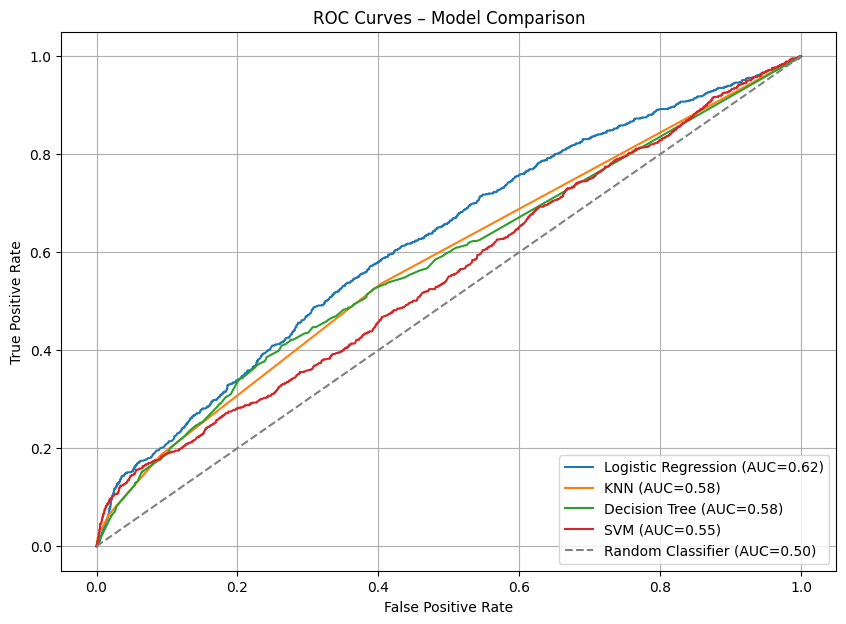

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier (AUC=0.50)", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### Questions